## ACM SIGCHI Summer School on Computational Interaction
#### Inference, optimization and modeling for the engineering of interactive systems
#### 12-17 June 2017
##### Lucerne, Switzerland, ETH Zurich
-----

# Inferring typing behaviour: II

In [2]:
import numpy as np
import sklearn.datasets, sklearn.linear_model, sklearn.neighbors
import sklearn.manifold, sklearn.cluster
import matplotlib.pyplot as plt
import scipy.stats
import sys, os, time
import pymc as mc
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18.0, 10.0)


In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;
OutputArea.prototype._should_scroll = function(){return false};

<IPython.core.display.Javascript object>

## MCMC in practice: sampling issues
<a id="sampling"> </a>

The **great thing** about MCMC approaches is that you can basically write down your model and then run inference directly. There is no need to derive complex approximations, or to restrict ourselves to limited models for which we can compute answers analyitically.

MCMC allows us to use distributions *we can't even sample from directly*. First we couldn't calculate the evidence P(B), so we integrated; but we couldn't solve the integral, so we sampled; but then we couldn't directly sample from the distribution so we used MCMC. It's a very general approach! (approaches like approximate Bayesian computation (ABC) let us even do inference when we can't **evaluate** the likelihood, never mind sample from it)

The **bad thing** about MCMC approaches is that, even though it will do the "right thing" *asymptotically*, the choice of sampling strategy has a very large influence for the kind of sample runs that are practical to execute.

Bayesian inference should depend only on the priors and the evidence observed; but MCMC approaches also depend on the sampling strategy used to approximate the posterior. 

## How MCMC works
We'll briefly describe how MCMC actually works, its limitations, and how we can detect MCMC problems and correct for them.


### Rejection sampling

The simplest way to perform Monte Carlo sampling for a distribution we can't sample directly is to do **rejection sampling**. We have a distribution we want to sample given by a pdf $p(x)$, and instead sample from an easy distribution $q(x)$, (usually uniform, i.e. a box) where $q(x)>p(x) \forall x$. Then, we draw a new sample $x_q$ from $q(x)$ (horizontal sample) and then sample uniformly from $x_s = [0,x_q]$ (vertical sample) and see if $x_s<f(x_q)$. If we so we keep it as a draw from the distribution, otherwise we reject it.



Fraction under the curve: 0.07


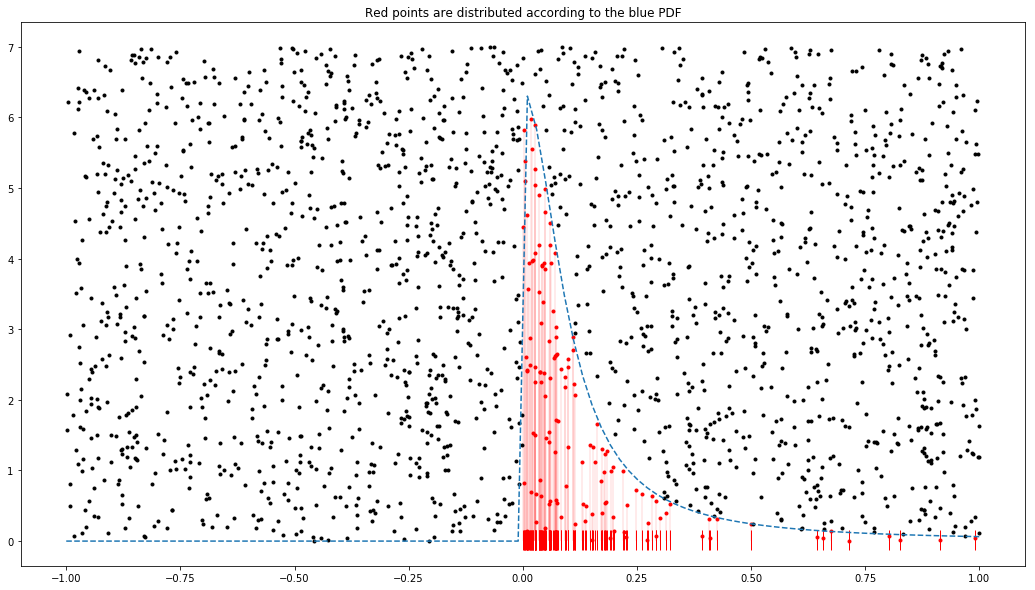

In [4]:
def rejection_sample(p,interval_x, interval_y, n):
    xs = np.random.uniform(interval_x[0], interval_x[1],(n,))    
    ys = np.random.uniform(interval_y[0], interval_y[1],(n,))        
    kept  = p(xs)>ys
    return kept, np.logical_not(kept), xs, ys

def odd_pdf(x):
    return scipy.stats.halfcauchy.pdf(x, scale=0.1)

kept, rejected, xs, ys = rejection_sample(odd_pdf, [-1,1], [0,7], 2000)
plt.plot(xs[kept], ys[kept], 'r.')

plt.plot(xs[kept], np.zeros_like(xs[kept])+0.01, 'r|', markersize=20)
for x,y in zip(xs[kept], ys[kept]):
    plt.plot([x,x], [0.01,y], 'r', alpha=0.1)

plt.plot(xs[rejected], ys[rejected], 'k.')

xf = np.linspace(-1,1,100)
plt.plot(xf,odd_pdf(xf), '--')

print "Fraction under the curve: %.2f" % (np.sum(kept) / float(len(xs)))
plt.title("Red points are distributed according to the blue PDF")        

### Rejection sampling in high-dimension
This is easy to implement, but works very poorly in *high dimensions* because the rejection rate increases exponentially with increasing dimension. We had about 5% acceptance in the above example: in 10D for a similar distribution, we would have an acceptance rate of $9\times 10^{-14}$: in practice we would *never* find a sample underneath the PDF by chance alone!

### Metropolis-Hastings
Metropolis-Hastings (or just plain Metropolis) takes a different approach, and is able to work in high-dimensional spaces. Metropolis samples also uses an auxiliary distribution $q(x)$, but it uses this to **wander around** in the distribution space, accepting jumps to new positions based on both $q(x)$ and $p(x)$.  This random walk (a **Markov chain**, because we make a random jump conditioned only on where we currently are) is a the "Markov Chain" bit of "Markov Chain Monte Carlo".

We just take our current position $x$, and propose a new position $x^\prime = x + x_q$, where $x_q$ is a random sample drawn from $q(x)$. This makes local steps in the space of the probability density. If $q(x)$ has a simple, symmetric form (e.g. is Gaussian), there is a very simple formula to decide whether to accept or reject a step from $p(x)$ to a new candidate position $p(x^\prime)$:
$$
p(\text{accept}) = \begin{cases} p(x^\prime)/p(x), & p(x)>=p(x^\prime) \\  1, & p(x)<p(x^\prime) \end{cases} $$

The asymmetric case is only slightly more involved, but it is very unusual to need to use it.

Amazingly, this simple procedure will (in the limit!) take unbiased samples from the complete posterior distribution. In practice, convergence can be difficult to achieve, especially in higher dimensions, with multi-modal posteriors.

In [5]:
def metropolis(p,q,x_init,n):
    # Perform Metropolis MCMC sampling.
    # p(x): a function that can be evaluated anywhere. p(x) returns the value of p at x
    # q(): a function q that draws a sample from a symmetric distribution and returns it
    # x_init: a starting point
    # n: number of samples
    x = x_init
    
    samples = []
    rejected = [] # we only keep the rejected samples to plot them later
    for i in range(n):
        # find a new candidate spot to jump to
        x_prime = x + q()
        # if it's better, go right away
        if p(x_prime)>p(x):
            x = x_prime
            samples.append(x_prime)            
        else:
            # if not, go with probability proportional to the
            # ratio between the new point and the current one
            pa = p(x_prime)/p(x)
            if np.random.uniform(0,1)<pa:
                x = x_prime
                samples.append(x_prime)
            else:
                rejected.append(x_prime)
                
    return np.array(samples), np.array(rejected)

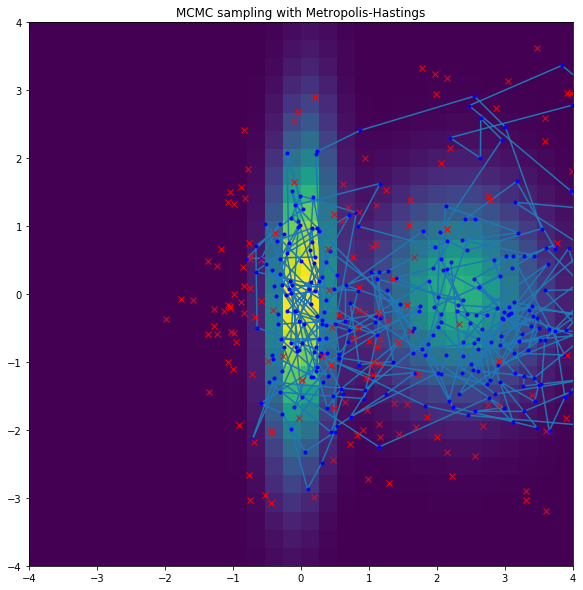

In [20]:
# test the sampling process
# create an interesting distribution p
A = np.array([[0.15, 0.9], [-0.1, 2.5]])
p1 = lambda x:scipy.stats.multivariate_normal(mean=[0,0], cov=A).pdf(x)
p2 = lambda x:scipy.stats.multivariate_normal(mean=[3,0], cov=np.eye(2)).pdf(x)
p = lambda x:p1(x)*0.5+p2(x)*0.5
# create a proposal distribution, with std. dev. 0.25
q = lambda: np.random.normal(0,0.75,(2,))

# make 500 MCMC steps
accept, reject = metropolis(p,q,[0.1, 0.3], 500)

# plot a heatmap of the distribution, along with the
# accepted and rejected samples from that MCMC chain
plt.figure(figsize=(10,10))
plt.plot(accept[:,0], accept[:,1])
plt.plot(accept[:,0], accept[:,1], 'b.')
plt.plot(reject[:,0], reject[:,1], 'rx')
x,y = np.meshgrid(np.linspace(-5,5,30), np.linspace(-4,4,30))
plt.imshow(p(np.dstack([x,y])), extent=[-4,4,-4,4], cmap='viridis')
plt.grid("off")
plt.title("MCMC sampling with Metropolis-Hastings")        

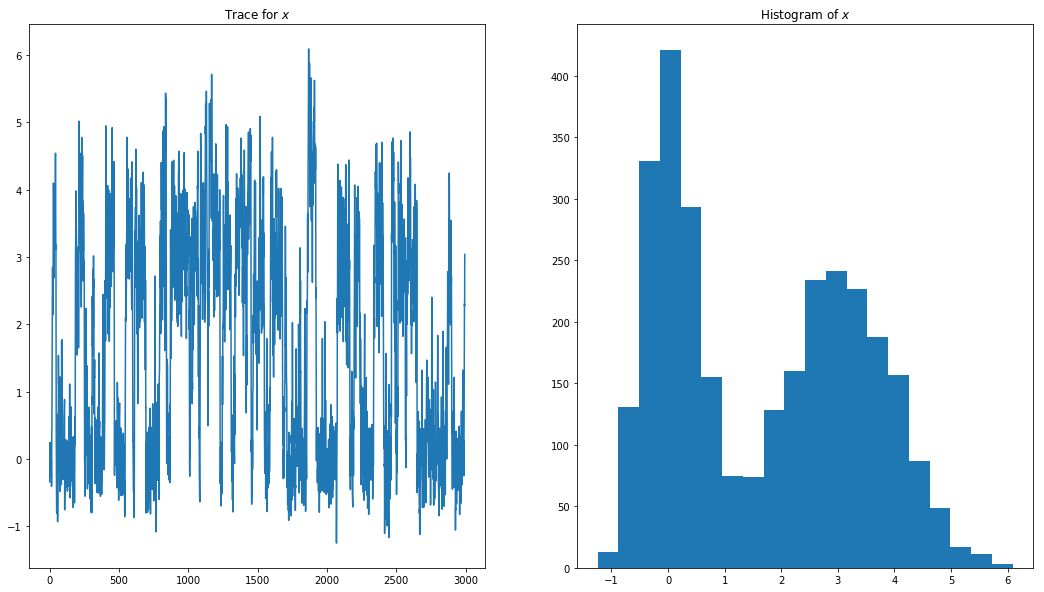

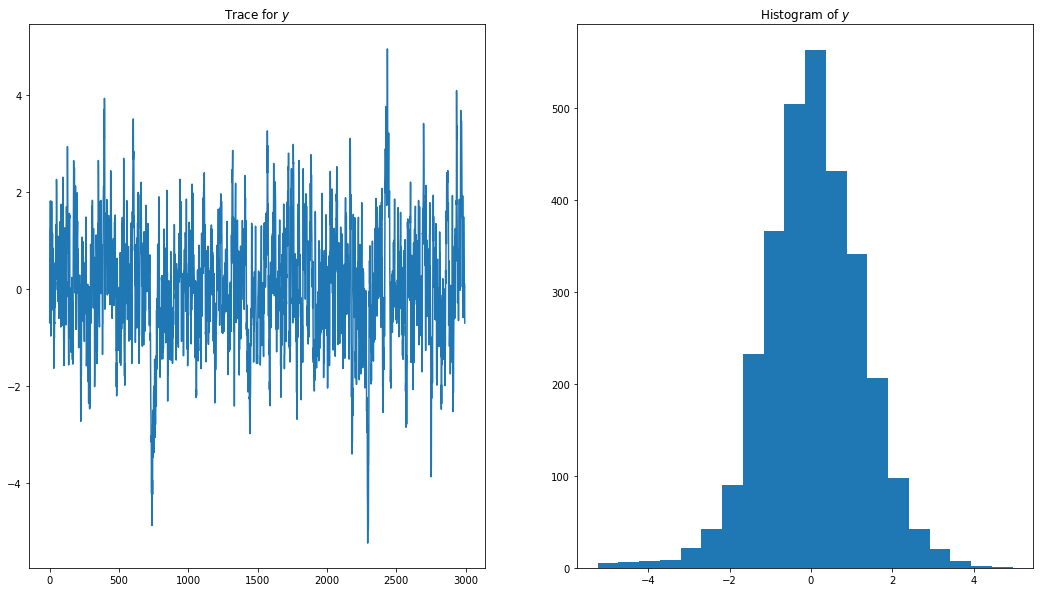

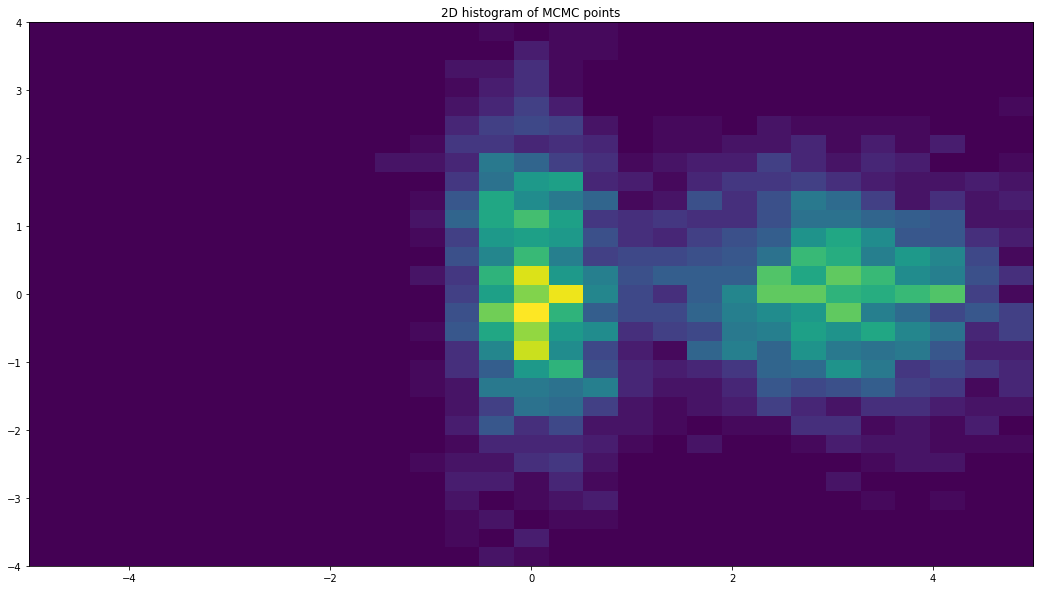

In [22]:
# run the chain for longer, and plot the trace and the histogram of the variable
accept, reject = metropolis(p,q,[0.1, 0.3], 5000)
plt.subplot(1,2,1)
plt.plot(accept[:,0])
plt.title("Trace for $x$")
plt.subplot(1,2,2)
plt.hist(accept[:,0], bins=20)
plt.title("Histogram of $x$")

plt.figure()

plt.plot(accept[:,1])
plt.subplot(1,2,1)
plt.title("Trace for $y$")
plt.plot(accept[:,1])
plt.subplot(1,2,2)
plt.title("Histogram of $y$")
plt.hist(accept[:,1], bins=20);

plt.figure()
xbins, ybins = np.linspace(-5,5,30), np.linspace(-4,4,30)
plt.hist2d(accept[:,0], accept[:,1], normed=True, bins=[xbins, ybins])
plt.title("2D histogram of MCMC points")


### Others
There are many other MCMC samplers, such as:
* **Gibbs** samplers, which are very efficient when we can sample from the conditional distribution (i.e. from one dimension of a distribution at a time), but not from the joint directly.
* **Hamiltonian** samplers, which extend Metropolis-like steps with "virtual physics" which pushes the samples in sensible directions (i.e. not down the gradient of the function!). These are implemented in PyMC3, as well as in the MCMC system **STAN**, and can work very well in otherwise intractably high-dimensional spaces.
* **Slice** samplers, which are very clever and efficient, but only work for 1-dimensional (univariate) distributions.



## Burn-in and thinning
MCMC tries to draw **independent, unbiased** samples from the posterior, but the sampling process (like Metropolis), is not inherently unbiased. For example, successive samples in a random walk are correlated and obviously not independent. 

And although the Markov Chain approach (under fairly relaxed assumptions) will asympotically sample from all of the posterior, if the random walk starts off very far from the bulk of the distribution, it will "wander in the wilderness" for some time before reaching significant probability density. This means early samples from the distribution might be unreasonably dense in very low probability regions in the posterior. How "good" the Markov chain is at sampling from the posterior is called **mixing**; some MCMC setups may mix very badly until they get warmed up.

To mitigate these two common issues, there are a couple of standard tricks: 
* **Burn-in**, which ignores the first $n$ samples from an MCMC draw, to make sure the chain is "mixing" well. Typically, several thousand samples might be ignored.
* **Thinnning**, which takes one sample from every $k$ consecutive samples from the chain, to reduce correlation. Values of raound 5-50 are common.

Tuning these is a matter of art!



In [1]:
## Burn-in and thinning plot

# introduce correlations
y = accept[:,1] 
x = np.arange(len(y))

# discard 400 samples, keep every 8th sample
burn = 400
thin = 8
plt.plot(x[0:burn], y[0:burn], 'r:')
plt.plot(x[burn::thin], y[burn::thin], 'go', markersize=8)
plt.plot(x[burn:], y[burn:], 'k:', alpha=0.1)
plt.plot(x[burn:], y[burn:], 'k.', alpha=0.1)


plt.axvline(burn, c='r')
plt.text(15,2.5,"Burn-in period")


NameError: name 'accept' is not defined

## Autocorrelation
To estimate what level of thinning is required, the **autocorrelation** of the trace is useful. This gives a view of how long the time dependence between samples is. The ideal case is that there is **no** time dependence and all samples are independent; this corresponds to a flat autocorrelation with a single peak at zero. 

Longer-time scale correlations appear as distinct peaks in the autocorrelation plot, and suggest thinning might be required.

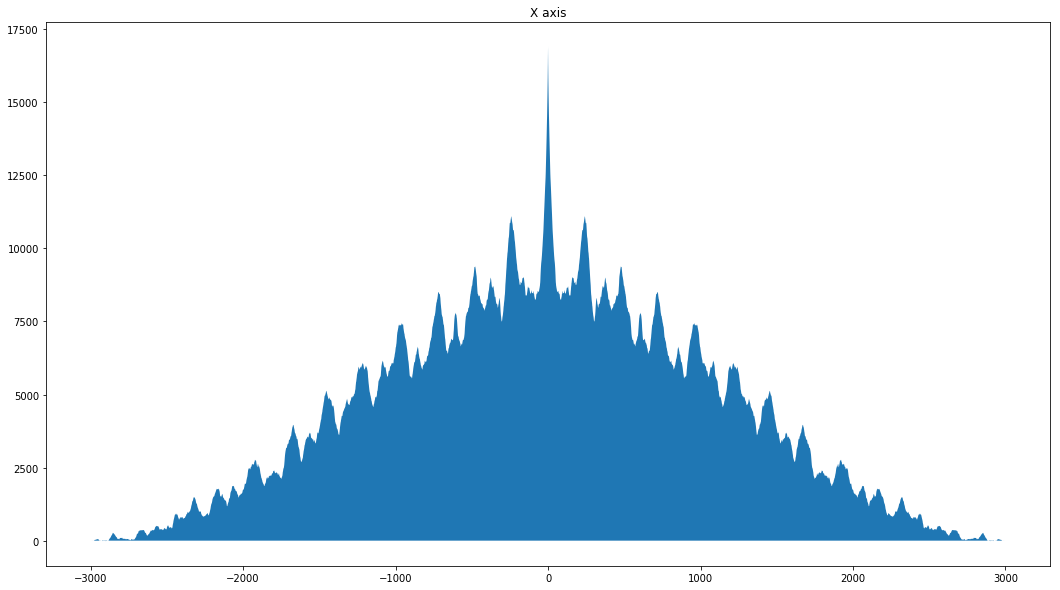

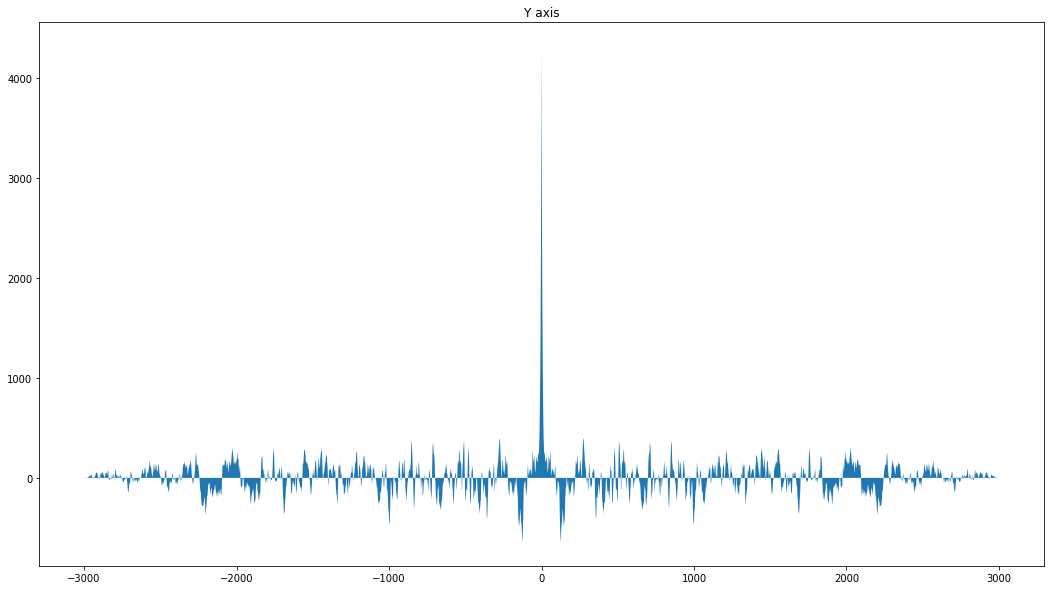

In [24]:
import scipy.signal
corr = scipy.signal.correlate(accept[:,0], accept[:,0])
plt.fill_between(np.arange(len(corr))-len(corr)/2, corr)
plt.title("X axis")
plt.figure()
corr = scipy.signal.correlate(accept[:,1], accept[:,1])
plt.fill_between(np.arange(len(corr))-len(corr)/2, corr)
plt.title("Y axis")



## Rejection rate
The **rejection rate** of a sampler is a common heuristic measure of how well the chain is mixing. A chain that always accepts a jump is probably just wandering around in a tiny, high-density area of the pace. A chain that almost never jumps is probably trying to sample too diversely, into very improbable regions of the space. Some **adaptive** algorithms, like adaptive Metropolis, optimise the rejection rate. A common technique is to try to hold the acceptance rate at 50%, adjusting the proposal distribution width (for Metropolis sampling) to be larger if the rate trends above this, and smaller if the rate drops too low.

This doesn't guarantee good mixing behaviour (why should 50% rejection be a good choice?), but it often does a reasonable job, especially if you have no prior information about the proposal distribution to use.


---------

In [33]:
print "Global acceptance rate: %.2f%%" % (100*len(accept)/float(len(accept)+len(reject)))


Global acceptance rate: 59.90%


[The PyMC manual](https://pymc-devs.github.io/pymc/modelchecking.html) explains a number of other diagnostic statistics and plots. **None of these are definitive**, but can give skilled MCMC practitioners insight into the operation of the sampling process.

If you're interested in learning more about MCMC, David Mackay's [book chapter](http://www.inference.phy.cam.ac.uk/mackay/itprnn/ps/356.384.pdf) is a good reference.

----
# Language modelling
<a id="bigram"> </a>

In the keystroke event datasets, we are predicting a sequence of discrete symbols, which has very regular and repetitive structure. Capturing the regularities in symbol sequences is **language modelling**. In traditional text entry, a language model captures natural language to improve typing performance, by constructing a predictive probabilisitic model. We'll look at using a language model to predict keystroke data in more depth that we have captured, using standard language modelling approaches.


## Bigram model
We can build a very simple probabilistic language model using *n-grams*, where we predict the next occurrence of a symbol given some observed previous sequences of $n$ symbols. 

**This is a Markov assumption; that the current state depends only on the previous state** (a fixed sequence of $n$ previous symbols can be bundled into a single previous state for the sake of argument).

A very basic model is a character-level bigram model, where we model the probability of a character $c_n$ given a previously seen character $c_{n-1}$, $p(c_n|c_{n-1})$. 

The probability distribution can be inferred from data simply by *counting* the occurrence of each pair $(c_{n-1}, c_{n})$ (the **empirical distribution**) and storing the result in a matrix which has dimensions $d \times d$ where $d$ is the number of distinct characters. This gives a joint distribution of character pairs. If we then normalise by dividing each row by the total count of that character, we approximate the conditional probability distribution  $p(c_n|c_{n-1})$. 



In [17]:
chars = "abcdefghijklmnopqrstuvwxyz '.,"
def numerify(string):
    # remove all but letters and space (note that this is not a very efficient way to do this process)
    # and then convert to 0=space, 1-27 = a-z
    #filtered_string = [max(1+ord(c.lower()) - ord('a'), 0) for c in string if c.isalpha() or c.isspace()]
    filtered_string = [chars.find(c.lower()) for c in string if c in chars]
    return filtered_string

def learn_bigram(string):
    # return a matrix with the bigram counts from string, including only letters and whitespace
    coded = numerify(string)
    joint = np.zeros((len(chars),len(chars)))
    # iterate over sequential pairs
    for prev, this in zip(coded[:-1], coded[1:]):
        joint[prev, this] += 1
    # note that we add on an epsilon to avoid dividing by zero!
    bigram = joint.T / (np.sum(joint, axis=0)+1e-6)
    return bigram.T, joint.T
            

In [18]:
with open("data/macbeth.txt") as f:
    macbeth_bigram, macbeth_joint = learn_bigram(f.read())

with open("data/candide.txt") as f:
    candide_bigram, candide_joint = learn_bigram(f.read())
    


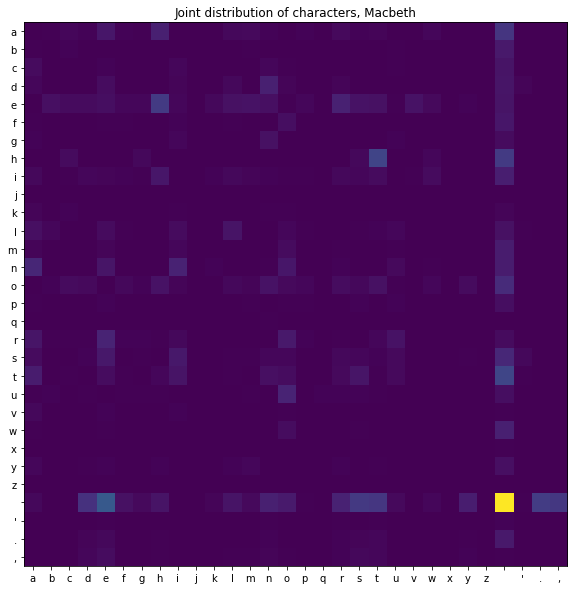

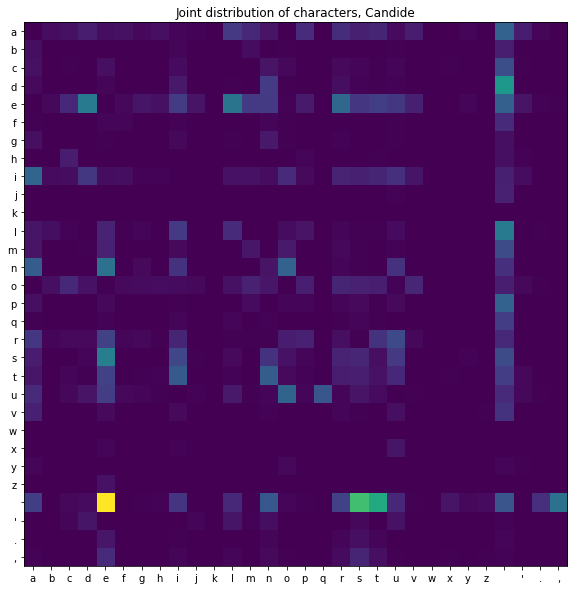

In [23]:
# The joint distribution
plt.imshow(macbeth_joint, interpolation='nearest', cmap="viridis")
plt.xticks(range(len(chars)), chars)
plt.yticks(range(len(chars)), chars)
plt.grid('off')
plt.title("Joint distribution of characters, Macbeth")
plt.figure()
plt.xticks(range(len(chars)), chars)
plt.yticks(range(len(chars)), chars)
plt.grid('off')
plt.title("Joint distribution of characters, Candide")
plt.imshow(candide_joint, interpolation='nearest', cmap="viridis")

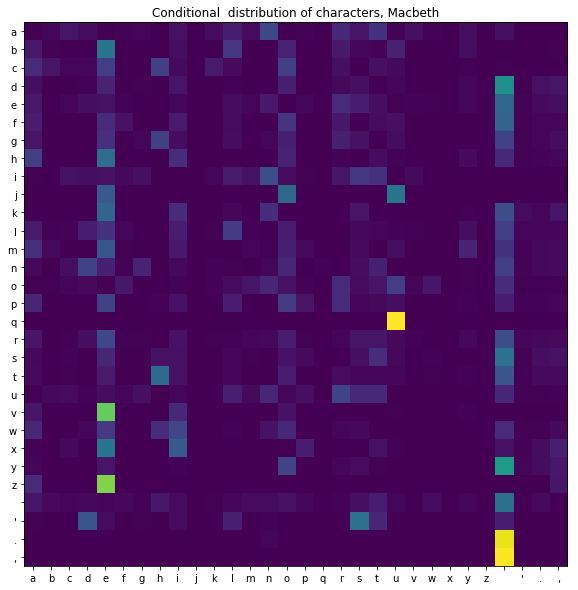

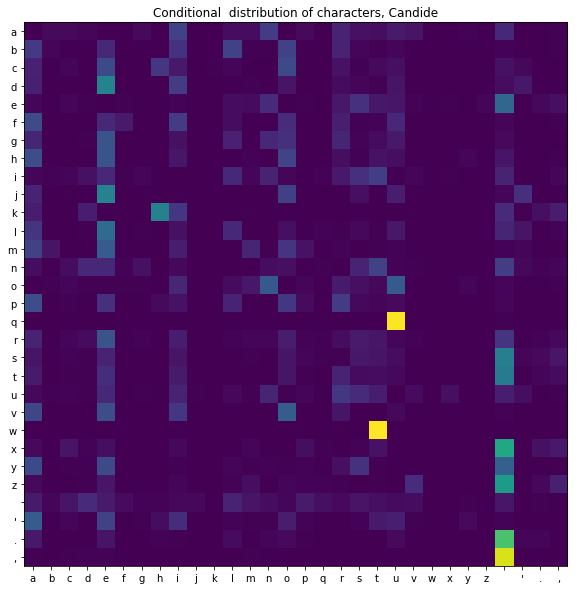

In [20]:
# The conditional distributions
plt.imshow(macbeth_bigram, interpolation='nearest', cmap="viridis")
plt.xticks(range(len(chars)), chars)
plt.yticks(range(len(chars)), chars)
plt.grid('off')
plt.title("Conditional  distribution of characters, Macbeth")
plt.figure()
plt.imshow(candide_bigram, interpolation='nearest', cmap="viridis")
plt.xticks(range(len(chars)), chars)
plt.yticks(range(len(chars)), chars)
plt.grid('off')
plt.title("Conditional  distribution of characters, Candide")

#### Log probabilities

The probability of multiple **independent** random variables taking on a set of values can be computed from the product:
$$p(x,y,z) = p(x)p(y)p(z)$$
and in general
$$p(x_1, \dots, x_n) = \prod_{i=1}^{n} x_i$$

We often have to have to compute such products, but to multiply lots of values $<1$ leads to numerical issues. Instead, we often prefer to manipluate *log probabilities*, which can be summed instead of multiplied:
$$\log p(x_1, \dots, x_n) = \sum_{i=1}^{n} \log p(x_i)$$

This is simply a numerical conveience.

In [25]:
 def log_likelihood_bigram(string, bigram):
    symbols = numerify(string)
    llik = 0
    # we sum the log probabilities to avoid numerical underflow
    for prev, this in zip(symbols[:-1], symbols[1:]):
        llik += np.log(bigram[prev, this]+1e-8) 
    return llik

In [29]:

def compare_logp(fname):
    print fname

    # open the files, and compare the log-lik of each text under the two models we have trained
    with open(fname) as f:
        text = f.read()
        mb_llik = log_likelihood_bigram(text, macbeth_bigram) / len(text)
        mm_llik = log_likelihood_bigram(text, candide_bigram) / len(text)
        diff = mb_llik - mm_llik
        print "\n logp Macbeth:\t % 17.2f\n logp Candide:\t% 10.2f\n Difference logp:\t% 10.2f" % (mb_llik, mm_llik, diff)
        if diff>0:
            print "\tModel favours: Macbeth"            
        else:
            print "\tModel favours: Candide"

    print
    
compare_logp("data/macbeth.txt") # Macbeth (Shakespeare)
compare_logp("data/candide.txt") # Candide (Voltaire)
compare_logp("data/romeo_juliet.txt") # Romeo and Juliet (Shakespeare)
compare_logp("data/lingenu.txt") # L'ingenu (Voltaire)



data/macbeth.txt

 logp Macbeth:	             -1.98
 logp Candide:	     -3.03
 Difference logp:	      1.05
	Model favours: Macbeth

data/candide.txt

 logp Macbeth:	             -2.89
 logp Candide:	     -2.15
 Difference logp:	     -0.74
	Model favours: Candide

data/romeo_juliet.txt

 logp Macbeth:	             -2.22
 logp Candide:	     -3.25
 Difference logp:	      1.02
	Model favours: Macbeth

data/lingenu.txt

 logp Macbeth:	             -2.92
 logp Candide:	     -2.17
 Difference logp:	     -0.75
	Model favours: Candide



------------

## Imputation
<a id="imputation"> </a>

In PyMC, variables can be **observed** (fixed) or **unobserved** (random). PyMC cycles through the array of known values for the **observed** variables and updates the rest of the graph.

But what if you want to ask "what if?"-style question? For example, if you knew the last key codes and timings, what is the predictive distribution over the possible times for the *next* key? 

PyMC implements this using **imputation**, where certain missing values in an observed variable can be inferred (*imputed*) from the rest of the model. **Masked arrays** are used to implement imputation; these allow arrays to have "blank" values, that PyMC can fill in automatically.

This approach creates one new random variable per missing data item; this can create very large models if you are not careful!




In [30]:
## Example, using the linear regression model from the last section:
import numpy.ma as ma # masked array support

## generate the data for the regression
x = np.sort(np.random.uniform(0,20, (50,)))
m = 2
c = 15
# Add on some measurement noise, with std. dev. 3.0
epsilon = data = np.random.normal(0,3, x.shape)
y = m * x + c + epsilon

## Now the imputation; we will try and infer missing some missing values of y (we still have the corresponding x)
## mark last three values of y invalid
y_impute = y[:]
y_impute[-3:] = 0
y_impute = ma.masked_equal(y_impute,0)
print "Y masked for imputation:", y_impute # we will see the last three entries with --

# create the model (exactly as before, except we switch "y_impute" for "y")
m_unknown = mc.Normal('m', 0, 0.01)
c_unknown = mc.Normal('c', 0, 0.001)
precision = mc.Uniform('precision', lower=0.001, upper=10.0)
x_obs = mc.Normal("x_obs", 0, 1, value=x, observed=True)
@mc.deterministic(plot=False)
def line(m=m_unknown, c=c_unknown, x=x_obs):
    return x*m+c
y_obs =  mc.Normal('y_obs', mu=line, tau=precision, value=y_impute, observed=True)
model = mc.Model([m_unknown, c_unknown, precision, x_obs, y_obs])

Y masked for imputation: [16.412909678630008 10.302089112013821 16.408865659709587
 19.179170054217067 12.092315594799018 18.456163138507133
 21.905616975313176 24.48669205002774 21.577430506723545 23.023110189121205
 18.871441599149385 20.11914549438085 21.937091966469673 23.935501045056867
 25.48193947288426 28.971979171889217 33.961778119823684 25.021643497638344
 24.610805286705453 30.949948177862822 33.598172033081276
 26.922299257886053 26.99873773415727 34.15180521424809 34.38660265529315
 31.38764135207938 32.12398928173063 32.49598469801656 34.983994069284726
 38.606174258483165 44.99172238550774 35.713676490545446 37.046760312316636
 43.07343658693998 41.27028813671817 45.99973021316966 44.15643835138349
 43.58255311898902 50.55207317737409 52.91325064116884 47.15415560362739
 50.43756944231494 45.71681833199447 45.67689018543264 38.63749428139353
 43.37231777833395 47.080518301092106 -- -- --]


In [31]:
# sample from the distribution
mcmc = mc.MCMC(model)
mcmc.sample(iter=20000, burn=2000, thin=5)

 [-----------------100%-----------------] 20000 of 20000 complete in 1.6 sec

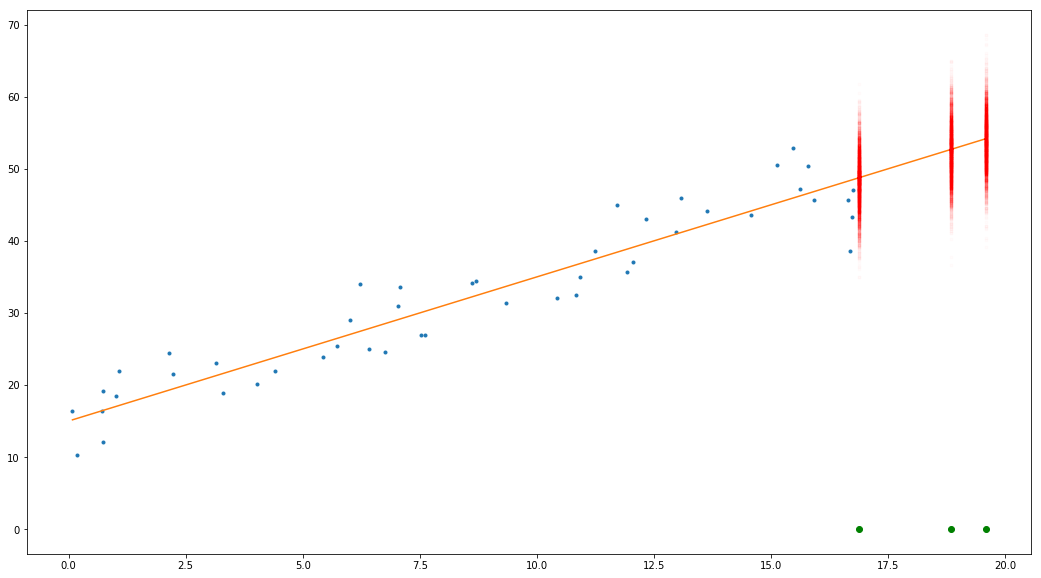

In [32]:
## now we will have three entries in the y_obs trace from this run
y_trace = mcmc.trace('y_obs')[:]

## the original data
plt.plot(x[:-3],y[:-3], '.')
plt.plot(x[-3:],y[-3:], 'go')
plt.plot(x,x*m+c, '-')

# samples from posterior predicted for the missing values of y
plt.plot(np.tile(x[-3], (len(y_trace[:,0]), 1)), y_trace[:,0],  'r.', alpha=0.01)
plt.plot(np.tile(x[-2], (len(y_trace[:,1]), 1)), y_trace[:,1],  'r.', alpha=0.01)
plt.plot(np.tile(x[-1], (len(y_trace[:,2]), 1)), y_trace[:,2],  'r.', alpha=0.01)



Note that, while it makes sense to be able to infer $x$ given $y$, as well as the $y$ given $x$ we just did, PyMC cannot automatically infer variables in this manner. It can only infer the "forward" path in the graph. In theory, if all the determinstic functions (like the line function) were invertible, then this reverse inference could be performed automatically without changing the model.

------------

----------------
# Challenge
<a id="challenge"> </a>

### Task: Build a better model of typing behaviour, and then test if you can predict inter-key times using imputation.

Extend the MCMC model to include a few more key classes (for example, space+enter, punctuation, numbers, letters). **Only choose at most four or five categories of keystroke, or your model will never converge in a reasonable time**.

In [34]:
import keys
# these are all the key types known to the keys module
print("\n".join(keys.get_key_types()))

letters
caps_lock
locks
numbers
tab
top_block
f_block
all_locks
whitespace
shifts
backspace
special
nav
allkeys
function
numpad
punct
delchar
ext_numpad
editing
insert_delete
web_nav
home_end
arrows
character_keys
enter
modifier
page
nonprint


In [36]:
# you can see what keys are included:
print keys.key_types['punct']

['equal sign', 'comma', 'dash', 'period', 'forward slash', 'grave accent', 'open bracket', 'back slash', 'close braket', 'single quote']


------------
Build a PyMC model that models the time to the next keystroke, dependent on:

* The previous **keystroke code category** *and* the current **keystroke code category**
* The previous keystroke press duration and the current keystroke press duration
* The time between the previous keystroke and this one (`delta_t`)


This model will be something like:

    if you just pressed a whitespace key and then you pressed a directional key, and you held the last key for 104ms, then the next key will happen in x milliseconds.

Use all of the keystroke data you have, but mask out the `delta_t` for rows 1000, 2000, 3000, 4000 and 5000, and impute the `delta_t` for these rows.

Plot a graph showing the predictive posterior against the true values of `delta_t`.

## Tips

* Start with the model in the previous example, and add in the masking and imputation code.
* Then, choose your own set of key classes to model.
* For discrete variables (e.g. keycode category, user_id) use observed Categorical variables
* Test the model **first**, running it and plotting the posterior predictive against the true values.
* Create new data lists for the previous key code, previous duration, and `delta_t`.
* Rerun the model and see if the predictions get better.

In [ ]:
# Solution

## the variables in the model should go in the list passed to Model
model = pymc.Model([])

## see the graphical representation of the model
show_dag(model)

## Construct a sampler
mcmc = pymc.MCMC(model)

## Sample from the result; you should try changing the number of iterations
mcmc.sample(iter=100000, burn=2000, thin=5)

## Use the trace methods from pymc to explore the distribution of values

## Plot the predictive distributions
